<a href="https://colab.research.google.com/github/dhanushka365/SLEnergyConsumptionPrediction/blob/main/EP_testv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!pip install --prefix {sys.prefix} pandas tensorflow scikit-learn matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Preparing Time Series Data**
The data represents hourly total service requests for years 2013-2014, starting with monday

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

#Load the sequence data from csv
df = pd.read_csv('/content/drive/MyDrive/hourly_csv/AEP_hourly.csv')
requests = pd.DataFrame(data=df,columns=['AEP_MW'])
#if any missing value fill it by previous value and convert all requests into integer type
requests.ffill(inplace=True)
requests["AEP_MW"]=requests["AEP_MW"].astype(float).astype(int)
#Review loaded data
#print(requests.dtypes)
#requests.head()
print(requests)

        AEP_MW
0        13478
1        12865
2        12577
3        12517
4        12670
...        ...
121268   21089
121269   20999
121270   20820
121271   20415
121272   19993

[121273 rows x 1 columns]


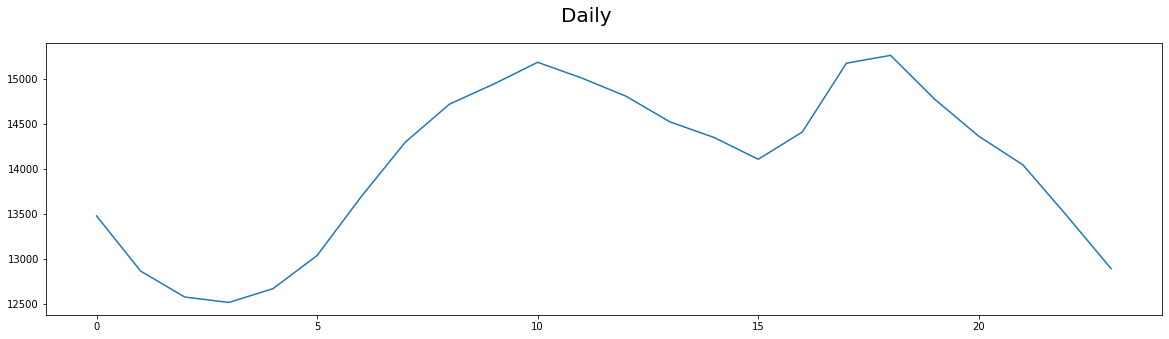

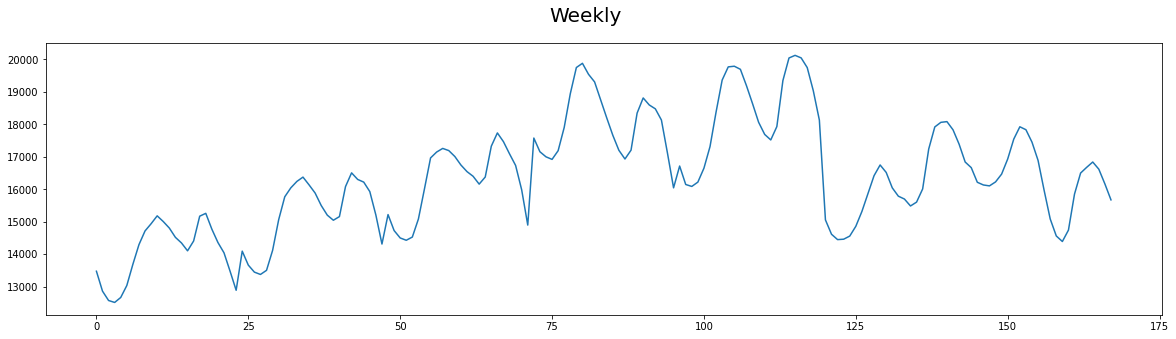

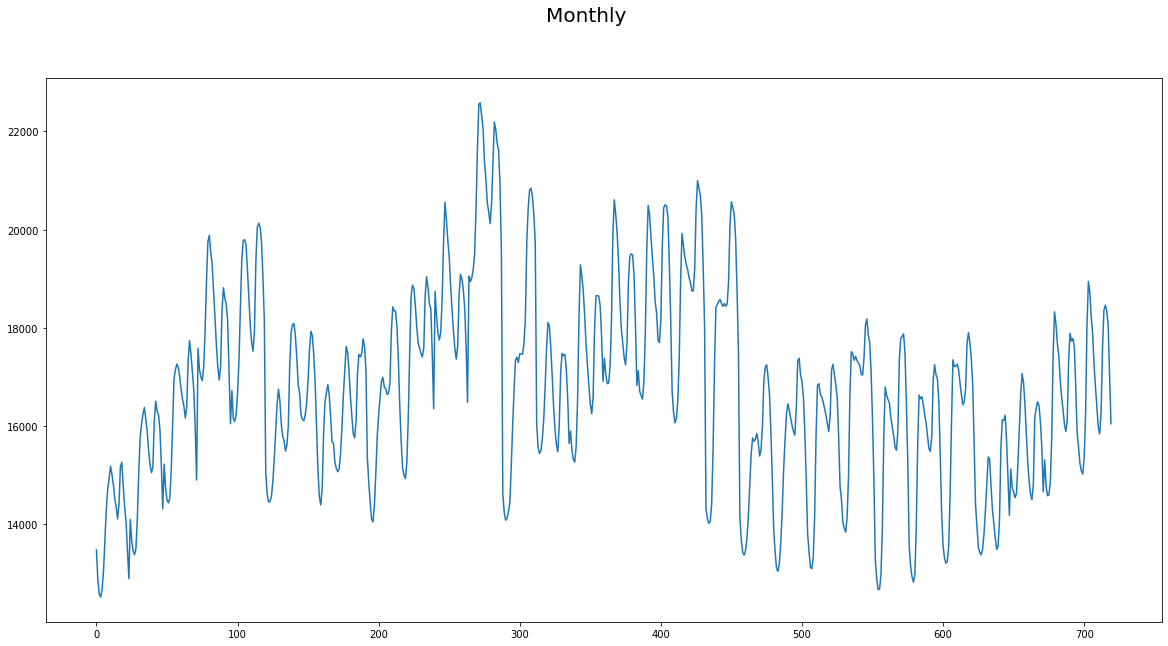

In [7]:
#plot the data loaded to visualize trends
#daily

plt.figure(figsize=(20,5)).suptitle("Daily",fontsize=20)
plt.plot(requests["AEP_MW"].head(24))
plt.show()

#weekly
plt.figure(figsize=(20,5)).suptitle("Weekly",fontsize=20)
plt.plot(requests["AEP_MW"].head(168))
plt.show()

#monthly
plt.figure(figsize=(20,10)).suptitle("Monthly",fontsize=20)
plt.plot(requests["AEP_MW"].head(720))
plt.show()


In [11]:
from sklearn.preprocessing import StandardScaler

#scale the data
print("Request Range before scaling:",min(requests.AEP_MW),max(requests.AEP_MW))
scaler = StandardScaler()
scaled_requests = scaler.fit_transform(requests)
print("Request Range after scaling:",min(scaled_requests),max(scaled_requests))

#Traing data has to be sequential
train_size =8041

#Number of samples to lookback for each sample
lookback =720

#sperate training and test data
train_requests = scaled_requests[0:train_size,:]

#Add an additional week for lookback
test_requests = scaled_requests[train_size-lookback:,:]

print("\n Shaped of Train ,Test :", train_requests.shape ,test_requests.shape)



Request Range before scaling: 9581 25695
Request Range after scaling: [-2.28391613] [3.93437215]

 Shaped of Train ,Test : (8041, 1) (113952, 1)


# Build a LSTM model with Keras
